In [1]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import wandb

from ipywidgets import IntSlider, interact
from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras import Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, GlobalAveragePooling3D,
                                     MaxPool3D, MaxPooling3D)
from keras.optimizers import Adam
from wandb.keras import WandbCallback

import keras_applications_3d as ka3d
from keras_applications_3d import vgg16, vgg19, resnet, resnet_v2, densenet

import splitfolders
import nibabel as nib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data loading and preprocessing

In [3]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset()     

Dataset arranged in ./data


In [4]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

train_set, train_labels = dataGenerator(data_dir, mode="train")
test_set, test_labels = dataGenerator(data_dir, mode="val")
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

batch_size = 4
nb_classes = 4
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC")
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC")
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC")

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Train set size:  457
Validation set size:  115
Test set size:  146
Shape of one MRI element: (4, 40, 40, 80, 1)
Train label example after loading: [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
Shape of one batch: (4, 40, 40, 80, 1)
Test label example after loading: [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Scan Visualization

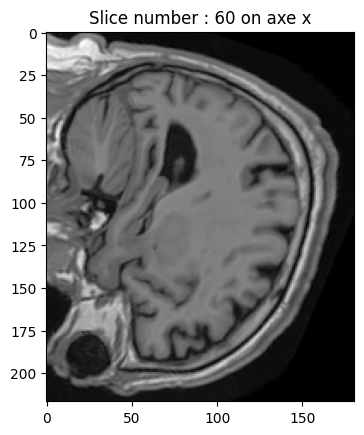

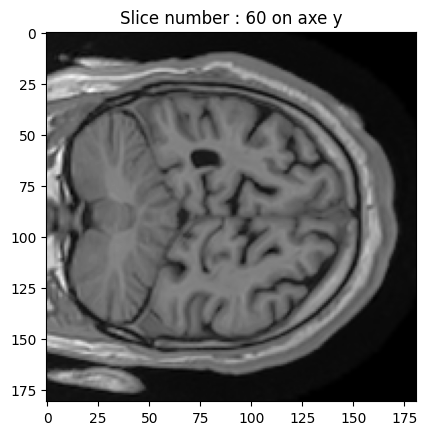

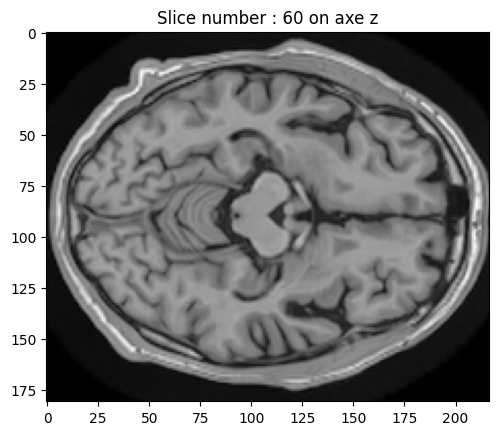

In [5]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()
    
img = nib.load(train_set[0])
show_2D(img.get_fdata(), 60, "x")
show_2D(img.get_fdata(), 60, "y")
show_2D(img.get_fdata(), 60, "z")

Imbalanced Data

{'AD': 191, 'CN': 227, 'PMCI': 171, 'SMCI': 129}


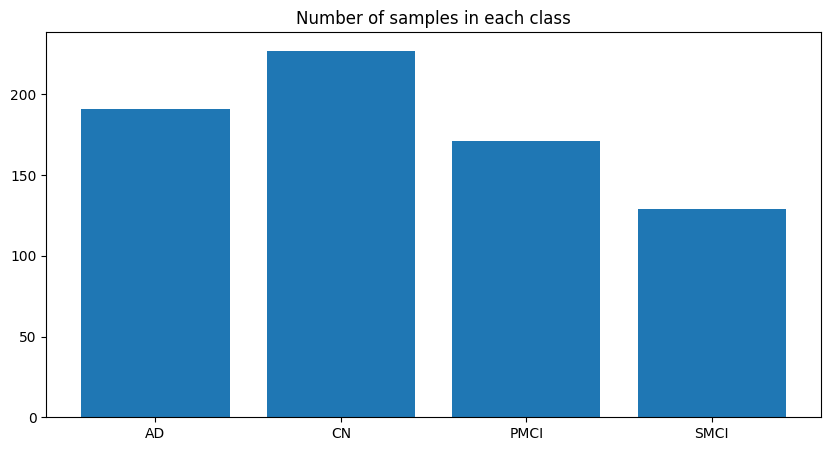

In [6]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["AD", "CN", "PMCI", "SMCI"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

if nb_classes == 2:
    class_counts["AD"] = class_counts["AD"] + class_counts["PMCI"]
    del class_counts["PMCI"]
    class_counts["CN"] = class_counts["CN"] + class_counts["SMCI"]
    del class_counts["SMCI"]

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

3D Convolutional Neural Network

In [11]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.2)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-3),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 activation_8 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_9 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 20, 20, 40, 8)     0         
 g3D)                                                            
                              

Model training

In [12]:
# checkpoint
filepath="classifier3D-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [16]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=20,
)

Epoch 1/20
115/115 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.3063
Epoch 1: val_accuracy did not improve from 0.34821
115/115 [==============================] - 69s 603ms/step - loss: 1.3685 - accuracy: 0.3063 - val_loss: 1.3587 - val_accuracy: 0.3482 - lr: 2.0000e-04
Epoch 2/20
115/115 [==============================] - ETA: 0s - loss: 1.3700 - accuracy: 0.3085
Epoch 2: val_accuracy did not improve from 0.34821
115/115 [==============================] - 68s 587ms/step - loss: 1.3700 - accuracy: 0.3085 - val_loss: 1.3581 - val_accuracy: 0.3482 - lr: 2.0000e-04
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.3151
Epoch 3: val_accuracy did not improve from 0.34821
115/115 [==============================] - 70s 607ms/step - loss: 1.3654 - accuracy: 0.3151 - val_loss: 1.3576 - val_accuracy: 0.3482 - lr: 2.0000e-04
Epoch 4/20
115/115 [==============================] - ETA: 0s - loss: 1.3715 - accuracy: 0.3085
Epoch 4: v

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


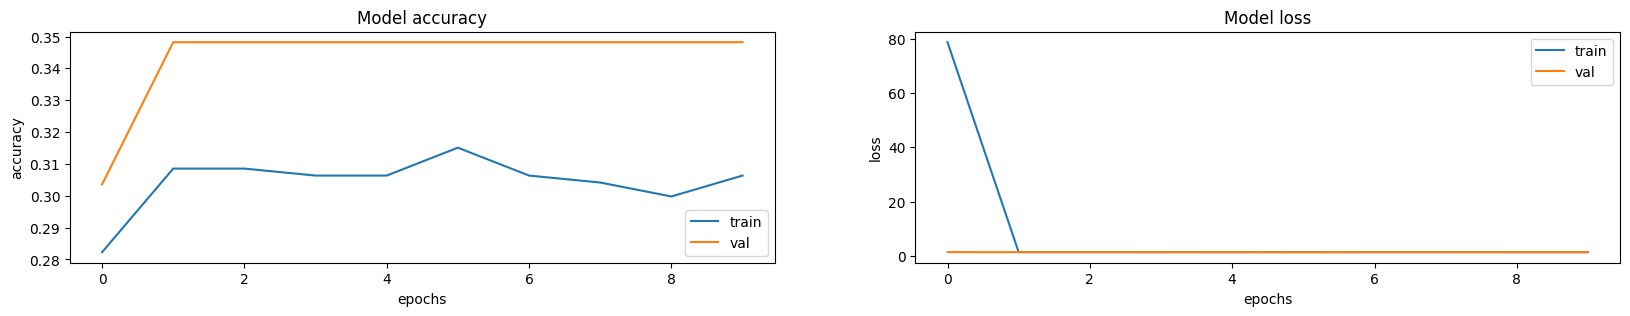

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [15]:
model.evaluate(test_sequence, verbose=1)

37/37 [==============================] - 18s 493ms/step - loss: 1.3671 - accuracy: 0.3151


[1.36710524559021, 0.31506848335266113]